In [79]:
import pandas as pd
import tensorflow as tf
import numpy as np
import keras_tuner as kt
from tensorflow import keras
import matplotlib.pyplot as plt

In [80]:
pd.set_option('display.max_columns', None)

In [81]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

In [82]:
raw_data = load_data("Drone_Data/deauth_data_fused.csv")
raw_data.head()

,timestamp,mid,x,y,mpitch,mroll,myaw,z,pitch,roll,yaw,vgx,vgy,vgz,templ,temph,tof,h,bat,baro,flight_time,agx,agy,agz,mpitch.1,mroll.1,myaw.1,timestamp_c,frame.number,frame.len,wlan.ta,wlan.sa,wlan.ra,wlan.da,wlan.bssid,wlan.duration,wlan.frag,wlan.seq,wlan.fc.type,wlan.fc.subtype,wlan.flags,wlan.fcs,wlan.fcs.status,wlan.qos,wlan.qos.priority,wlan.qos.ack,wlan.ccmp.extiv,wlan.wep.key,data.len,radiotap.hdr_length,radiotap.antenna_signal,radiotap.signal_quality,radiotap.channel.flags.ofdm,radiotap.channel.flags.cck,wlan_radio.datarate,wlan_radio.channel,wlan_radio.frequency,wlan_radio.signal_strength (dbm),wlan_radio.Noise level (dbm),wlan_radio.SNR (db),wlan_radio.preamble,class
0,2024-04-24 16:42:32,-1,-100,-100,0,0,0,-100,0,0,-80,0,0,1,64,68,81,30,93,305.34,1,11.0,-12.0,-926.0,0,0,0,1.713995e+09,11,124,0,0,2,1,0,48,0,15,2,8,65,3850463446,2,0,0,0,326,0,51,35,-22,78,0,0,144.444,9,2452,-22,0,0,40,0
1,2024-04-24 16:42:32,-1,-100,-100,0,0,0,-100,0,0,-80,0,0,1,64,68,81,30,93,305.34,1,11.0,-12.0,-926.0,0,0,0,1.713995e+09,13,121,2,0,1,1,0,44,0,3941,2,8,66,1477863697,2,0,0,0,4,0,51,32,-28,81,1,0,54.000,9,2452,-28,0,0,20,0
2,2024-04-24 16:42:32,-1,-100,-100,0,0,0,-100,0,0,-80,0,0,1,64,68,85,40,93,305.44,1,3.0,-18.0,-934.0,0,0,0,1.713995e+09,15,116,1,1,2,0,0,44,0,27,2,8,65,3874222033,2,0,0,0,28,0,46,32,-40,84,1,0,54.000,9,2452,-40,0,0,20,0
3,2024-04-24 16:42:32,-1,-100,-100,0,0,0,-100,0,0,-80,0,0,1,64,68,85,40,93,305.44,1,3.0,-18.0,-934.0,0,0,0,1.713995e+09,18,119,2,1,0,0,0,48,0,10,2,8,66,1894789517,2,0,0,0,27,0,46,35,-30,78,0,0,130.000,9,2452,-30,0,0,40,0
4,2024-04-24 16:42:32,-1,-100,-100,0,0,0,-100,0,0,-80,0,0,0,64,68,89,40,93,305.44,1,-6.0,2.0,-945.0,0,0,0,1.713995e+09,29,284,1,1,2,0,0,44,0,28,2,8,73,251167194,2,0,0,0,29,0,214,32,-40,78,1,0,48.000,9,2452,-40,0,0,20,0


In [83]:
count_all_na = raw_data.isna().any(axis=1).sum()
print("Number of rows with any NaN values:", count_all_na)

Number of rows with any NaN values: 0


In [84]:
columns_with_one_value = raw_data.columns[raw_data.nunique() == 1]

print("Columns with only one unique value:")
print(columns_with_one_value)

Columns with only one unique value:
Index(['wlan.frag', 'wlan.qos.ack', 'wlan_radio.Noise level (dbm)',
       'wlan_radio.SNR (db)'],
      dtype='object')


In [85]:
def drop_columns(data):
    data['timestamp'] = pd.to_datetime(data['timestamp'])

    # Sort by the 'Timestamp' column
    data = data.sort_values(by='timestamp')
    
    # Drop the 'Timestamp' column
    data = data.drop(columns=['timestamp', 'timestamp_c', 'frame.number', 'frame.len', 'wlan_radio.Noise level (dbm)', 'wlan_radio.SNR (db)', 'wlan.frag', 'wlan.qos.ack', 'mpitch.1', 'mroll.1', 'myaw.1'])
    
    # Reset the index (optional, for cleaner output)
    data = data.reset_index(drop=True)

    return data


In [86]:
physical_columns = [
    'mid', 'x', 'y', 'z', 'pitch', 'roll', 'yaw', 'vgx', 'vgy', 'vgz', 
    'templ', 'temph', 'tof', 'h', 'bat', 'baro', 'flight_time', 'agx', 'agy', 'agz'
]

# Assign a higher weight factor to the physical columns
weight_factor = .5  # Adjust this factor based on your needs

clean_data = raw_data

# Multiply the physical columns by the weight factor
clean_data[physical_columns] = clean_data[physical_columns] * weight_factor

In [87]:
clean_data.head()

,timestamp,mid,x,y,mpitch,mroll,myaw,z,pitch,roll,yaw,vgx,vgy,vgz,templ,temph,tof,h,bat,baro,flight_time,agx,agy,agz,mpitch.1,mroll.1,myaw.1,timestamp_c,frame.number,frame.len,wlan.ta,wlan.sa,wlan.ra,wlan.da,wlan.bssid,wlan.duration,wlan.frag,wlan.seq,wlan.fc.type,wlan.fc.subtype,wlan.flags,wlan.fcs,wlan.fcs.status,wlan.qos,wlan.qos.priority,wlan.qos.ack,wlan.ccmp.extiv,wlan.wep.key,data.len,radiotap.hdr_length,radiotap.antenna_signal,radiotap.signal_quality,radiotap.channel.flags.ofdm,radiotap.channel.flags.cck,wlan_radio.datarate,wlan_radio.channel,wlan_radio.frequency,wlan_radio.signal_strength (dbm),wlan_radio.Noise level (dbm),wlan_radio.SNR (db),wlan_radio.preamble,class
0,2024-04-24 16:42:32,-0.5,-50.0,-50.0,0,0,0,-50.0,0.0,0.0,-40.0,0.0,0.0,0.5,32.0,34.0,40.5,15.0,46.5,152.67,0.5,5.5,-6.0,-463.0,0,0,0,1.713995e+09,11,124,0,0,2,1,0,48,0,15,2,8,65,3850463446,2,0,0,0,326,0,51,35,-22,78,0,0,144.444,9,2452,-22,0,0,40,0
1,2024-04-24 16:42:32,-0.5,-50.0,-50.0,0,0,0,-50.0,0.0,0.0,-40.0,0.0,0.0,0.5,32.0,34.0,40.5,15.0,46.5,152.67,0.5,5.5,-6.0,-463.0,0,0,0,1.713995e+09,13,121,2,0,1,1,0,44,0,3941,2,8,66,1477863697,2,0,0,0,4,0,51,32,-28,81,1,0,54.000,9,2452,-28,0,0,20,0
2,2024-04-24 16:42:32,-0.5,-50.0,-50.0,0,0,0,-50.0,0.0,0.0,-40.0,0.0,0.0,0.5,32.0,34.0,42.5,20.0,46.5,152.72,0.5,1.5,-9.0,-467.0,0,0,0,1.713995e+09,15,116,1,1,2,0,0,44,0,27,2,8,65,3874222033,2,0,0,0,28,0,46,32,-40,84,1,0,54.000,9,2452,-40,0,0,20,0
3,2024-04-24 16:42:32,-0.5,-50.0,-50.0,0,0,0,-50.0,0.0,0.0,-40.0,0.0,0.0,0.5,32.0,34.0,42.5,20.0,46.5,152.72,0.5,1.5,-9.0,-467.0,0,0,0,1.713995e+09,18,119,2,1,0,0,0,48,0,10,2,8,66,1894789517,2,0,0,0,27,0,46,35,-30,78,0,0,130.000,9,2452,-30,0,0,40,0
4,2024-04-24 16:42:32,-0.5,-50.0,-50.0,0,0,0,-50.0,0.0,0.0,-40.0,0.0,0.0,0.0,32.0,34.0,44.5,20.0,46.5,152.72,0.5,-3.0,1.0,-472.5,0,0,0,1.713995e+09,29,284,1,1,2,0,0,44,0,28,2,8,73,251167194,2,0,0,0,29,0,214,32,-40,78,1,0,48.000,9,2452,-40,0,0,20,0


In [88]:
clean_data = drop_columns(raw_data)
columns_with_one_value = clean_data.columns[clean_data.nunique() == 1]

print("Columns with only one unique value:")
print(columns_with_one_value)

Columns with only one unique value:
Index([], dtype='object')


In [89]:
def normalize_data(df, columns = None):
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    continuous_cols = ['x', 'y', 'z', 'pitch', 'roll', 'yaw', 'vgx', 'vgy', 'vgz', 'bat', 'flight_time', 'baro', 'templ', 'temph', 'tof', 'h',
                      'agx', 'agy', 'agz', 'wlan.fcs']
    scaler = MinMaxScaler()
    df[continuous_cols] = scaler.fit_transform(df[continuous_cols])

In [162]:
normalize_data(clean_data)
clean_data

,mid,x,y,mpitch,mroll,myaw,z,pitch,roll,yaw,vgx,vgy,vgz,templ,temph,tof,h,bat,baro,flight_time,agx,agy,agz,wlan.ta,wlan.sa,wlan.ra,wlan.da,wlan.bssid,wlan.duration,wlan.seq,wlan.fc.type,wlan.fc.subtype,wlan.flags,wlan.fcs,wlan.fcs.status,wlan.qos,wlan.qos.priority,wlan.ccmp.extiv,wlan.wep.key,data.len,radiotap.hdr_length,radiotap.antenna_signal,radiotap.signal_quality,radiotap.channel.flags.ofdm,radiotap.channel.flags.cck,wlan_radio.datarate,wlan_radio.channel,wlan_radio.frequency,wlan_radio.signal_strength (dbm),wlan_radio.preamble,class
0,-0.5,0.374532,0.353357,0,0,0,0.252525,0.692308,0.625,0.212291,0.5,0.5,0.833333,0.272727,0.2500,0.258427,0.318182,0.924528,0.817808,0.0,0.643678,0.344916,0.901502,1,1,2,0,1,44,54,2,8,65,0.582928,2,0,0,55,0,58,32,-34,84,1,0,54.000,9,2452,-34,20,1
1,-0.5,0.374532,0.353357,0,0,0,0.252525,0.615385,0.625,0.212291,0.5,0.5,0.777778,0.272727,0.2500,0.297753,0.363636,0.924528,0.834247,0.0,0.620690,0.347490,0.903710,0,0,2,1,1,48,661,2,8,65,0.339658,2,0,0,979,0,51,35,-20,69,0,0,144.444,9,2452,-20,40,1
2,-0.5,0.374532,0.353357,0,0,0,0.252525,0.615385,0.625,0.212291,0.5,0.5,0.777778,0.272727,0.2500,0.297753,0.363636,0.924528,0.834247,0.0,0.620690,0.347490,0.903710,2,1,0,0,1,48,17,2,8,66,0.488997,2,0,0,246,0,46,35,-36,66,0,0,130.000,9,2452,-36,40,1
3,-0.5,0.374532,0.353357,0,0,0,0.252525,0.615385,0.625,0.212291,0.5,0.5,0.777778,0.272727,0.2500,0.297753,0.363636,0.924528,0.834247,0.0,0.620690,0.347490,0.903710,1,1,2,0,1,44,61,2,8,65,0.697693,2,0,0,62,0,46,32,-34,81,1,0,54.000,9,2452,-34,20,1
4,-0.5,0.374532,0.353357,0,0,0,0.252525,0.615385,0.625,0.212291,0.5,0.5,0.777778,0.272727,0.2500,0.297753,0.363636,0.924528,0.834247,0.0,0.620690,0.347490,0.903710,2,1,0,0,1,48,16,2,8,74,0.353987,2,0,0,245,0,213,35,-36,60,0,0,117.000,9,2452,-36,40,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21798,6.0,0.779026,0.862191,0,-69,-178,0.676768,0.538462,0.625,0.441341,0.5,0.5,0.555556,0.363636,0.3125,0.000000,0.090909,0.207547,0.409589,1.0,0.605911,0.350064,0.859099,2,1,0,0,0,48,2343,2,8,66,0.791863,2,0,0,10602,0,218,35,-32,87,0,0,130.000,9,2452,-32,40,0
21799,6.0,0.779026,0.862191,0,-69,-178,0.676768,0.538462,0.625,0.441341,0.5,0.5,0.555556,0.363636,0.3125,0.000000,0.090909,0.207547,0.419178,1.0,0.620690,0.359073,0.856007,1,1,2,0,0,44,2395,2,8,65,0.157518,2,0,0,10588,0,56,32,-24,81,1,0,54.000,9,2452,-24,20,0
21800,6.0,0.779026,0.862191,0,-69,-178,0.676768,0.538462,0.625,0.441341,0.5,0.5,0.555556,0.363636,0.3125,0.000000,0.090909,0.207547,0.419178,1.0,0.620690,0.359073,0.856007,2,1,0,0,0,48,2344,2,8,66,0.721249,2,0,0,10603,0,56,35,-34,69,0,0,130.000,9,2452,-34,40,0
21801,6.0,0.779026,0.862191,0,-69,-178,0.676768,0.538462,0.625,0.441341,0.5,0.5,0.555556,0.363636,0.3125,0.000000,0.090909,0.207547,0.419178,1.0,0.620690,0.359073,0.856007,0,0,2,1,0,48,2078,2,8,65,0.344876,2,0,0,12827,0,72,35,-26,63,0,0,144.444,9,2452,-26,40,0


In [91]:
print(clean_data['class'].value_counts())

class
1    14493
0     7310
Name: count, dtype: int64


In [181]:
def create_sequences(data, time_steps):
    X = []
    y = []
    data_X = np.delete(data, -1, axis=1)
    for i in range(len(data) - time_steps):
        row = [a for a in data_X[i:i+time_steps]]
        X.append(row)
        label = data[i+time_steps, -1]
        y.append(label)  # CLass is the last column
    return np.array(X), np.array(y)

In [182]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.layers import Input
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from keras_tuner import Hyperband
from tensorflow.keras import backend as K

In [183]:
clean_data['mid']

0       -0.5
1       -0.5
2       -0.5
3       -0.5
4       -0.5
        ... 
21798    6.0
21799    6.0
21800    6.0
21801    6.0
21802    6.0
Name: mid, Length: 21803, dtype: float64

In [184]:
time_steps = 5  # Set your time window, e.g., 10 timesteps
X, y = create_sequences(np.hstack([clean_data.drop(columns=['class']), clean_data['class'].values.reshape(-1, 1)]), time_steps)

# Split the data into training, validation, and test sets (80% train, 10% validation, 10% test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=10, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=10, stratify=y_temp)

In [186]:
def build_initial_model(input_shape):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(LSTM(units=64, return_sequences=False))  # Default LSTM units
    model.add(Dropout(rate=0.3))  # Default dropout
    model.add(Dense(units=64, activation="relu"))  # Default dense layer units
    model.add(Dense(1, activation="sigmoid"))
    model.compile(
        optimizer=Adam(learning_rate=1e-3),  # Default learning rate
        loss="binary_crossentropy",
        metrics=['accuracy'],
    )
    return model

In [187]:
LSTM_model = build_initial_model(X_train.shape[1:])
LSTM_model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                       │ (None, 64)                  │          29,440 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,665 (131.50 KB)

 Trainable params: 33,665 (131.50 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
def evaluate_model(X_train, y_train, X_test, y_test):
    
    class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
    )
    class_weights = dict(enumerate(class_weights))
    
    model = build_initial_model(X_train.shape[1:])
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_val, y_val))  # Adjust epochs/batch_size as needed

    # Predictions and F1 Score Evaluation
    y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Threshold 0.5
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1}")
    return model, history

In [189]:
LSTM_model, history = evaluate_model(X_train, y_train, X_test, y_test)

Epoch 1/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8883 - loss: 0.2707 - val_accuracy: 0.9486 - val_loss: 0.1068
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9499 - loss: 0.1140 - val_accuracy: 0.9509 - val_loss: 0.0973
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9492 - loss: 0.1070 - val_accuracy: 0.9523 - val_loss: 0.0926
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9540 - loss: 0.0991 - val_accuracy: 0.9555 - val_loss: 0.0945
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9545 - loss: 0.1019 - val_accuracy: 0.9560 - val_loss: 0.0904
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9550 - loss: 0.0964 - val_accuracy: 0.9555 - val_loss: 0.0843
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9603 - loss: 0.0906 - val_accuracy: 0.9578 - val_loss: 0.0865
Epoch 8/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9595 - loss: 0.0887 - val_accuracy: 0.

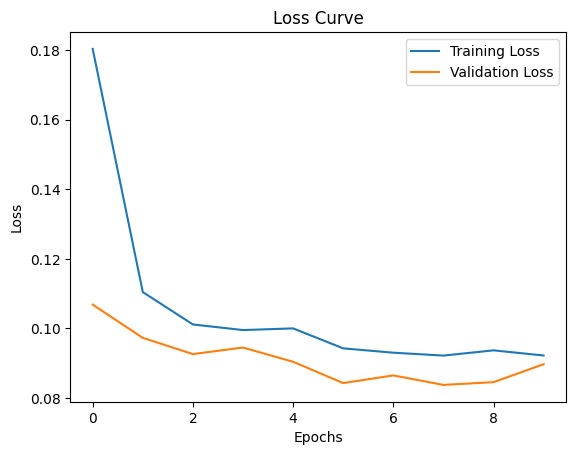

In [190]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [191]:
y_pred_probs = LSTM_model.predict(X_test)

y_pred = (y_pred_probs > .5).astype(int)  # Convert probabilities to binary predictions
y_pred = K.round(y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", f1)

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
F1-Score: 0.9687943262411348


In [192]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

[[ 726    5]
 [  83 1366]]


In [193]:
print(np.bincount(y_train.astype(int)))  # For training labels
print(np.bincount(y_test.astype(int)))

[ 5848 11590]
[ 731 1449]


In [194]:
@tf.keras.utils.register_keras_serializable()
def f1_metric(y_true, y_pred):
    y_pred = K.round(K.flatten(y_pred)) # Round predictions to the nearest integer (0 or 1)
    
    # True Positives, False Positives, False Negatives
    tp = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 1), K.floatx()))
    fp = K.sum(K.cast(K.equal(y_true, 0) & K.equal(y_pred, 1), K.floatx()))
    fn = K.sum(K.cast(K.equal(y_true, 1) & K.equal(y_pred, 0), K.floatx()))
    
    # Precision and Recall
    precision = tp / (tp + fp + K.epsilon())  # Add K.epsilon() to avoid division by zero
    recall = tp / (tp + fn + K.epsilon())
    
    # F1 Score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1

In [195]:
print(f1_metric(y_test, y_pred))

tf.Tensor(0.9687943, shape=(), dtype=float32)


In [196]:
clean_data.shape

(21803, 51)

In [197]:
X_train.shape

(17438, 5, 50)

In [198]:
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=X_train.shape[1:]))  # Adjust (50, 10) as per your input data shape
    
    # LSTM layer with units as a hyperparameter
    model.add(LSTM(units=hp.Int("units", min_value=32, max_value=128, step=32), return_sequences=False))
    
    # Dropout rate as a hyperparameter
    model.add(Dropout(rate=hp.Float("dropout", min_value=0.1, max_value=0.5, step=0.1)))
    
    # Add multiple hidden Dense layers, number of layers is a hyperparameter
    for i in range(hp.Int("num_hidden_layers", 1, 5)):  # You can adjust the range based on your needs
        model.add(Dense(units=hp.Int(f"dense_units_{i}", min_value=32, max_value=128, step=32), activation="relu"))
        model.add(Dropout(rate=hp.Float(f"dropout_{i}", min_value=0.1, max_value=0.5, step=0.1)))
    
    # Output layer
    model.add(Dense(1, activation="sigmoid"))
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [1e-3, 1e-4])),
        loss="binary_crossentropy",
        metrics=["accuracy", f1_metric],
    )
    return model


In [199]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

print('Test Set Evaluation:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall}')
print(f'Recall: {recall}')
print(f'f1: {f1}')
print(f'precision: {precision}')

Test Set Evaluation:
Accuracy: 0.9596
Recall: [0.99316005 0.94271912]
Recall: [0.99316005 0.94271912]
f1: [0.94285714 0.96879433]
precision: [0.8974042  0.99635303]


In [200]:
val_data = (X_val, y_val)


tuner = Hyperband(
    build_model,
    objective=kt.Objective("val_loss", direction="min"),  # Set F1 score as objective
    max_epochs=10,
    factor=3,
    directory="my_dir",
    project_name="f1_tuning"
)


Reloading Tuner from my_dir\f1_tuning\tuner0.json


In [201]:
tuner.search(
    X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[]
)

# Retrieve the best hyperparameters and model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
best_model = tuner.hypermodel.build(best_hps)

In [202]:
best_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 96)                  │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,185 (301.50 KB)

 Trainable params: 77,185 (301.50 KB)

 Non-trainable params: 0 (0.00 B)

In [203]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = best_model.fit(X_train, y_train, epochs=75, batch_size=32, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7954 - f1_metric: 0.8554 - loss: 0.4183 - val_accuracy: 0.8849 - val_f1_metric: 0.9113 - val_loss: 0.2119
Epoch 2/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8993 - f1_metric: 0.9231 - loss: 0.2222 - val_accuracy: 0.9505 - val_f1_metric: 0.9621 - val_loss: 0.1419
Epoch 3/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9317 - f1_metric: 0.9473 - loss: 0.1612 - val_accuracy: 0.9587 - val_f1_metric: 0.9678 - val_loss: 0.1080
Epoch 4/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9429 - f1_metric: 0.9567 - loss: 0.1332 - val_accuracy: 0.9560 - val_f1_metric: 0.9658 - val_loss: 0.0928
Epoch 5/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9466 - f1_metric: 0.9588 - loss: 0.1194 - val_accuracy: 0.9587 - val_f1_metric: 0.9677 - val_loss: 0.0840
Epoch 6/75
545/545 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9512 - f1_metric: 0.9626 - loss: 0.1053 - val_accuracy: 0.9656 - val_f1_me

In [204]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_probs = best_model.predict(X_test)
y_pred = (y_pred_probs > .5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

print('Test Set Evaluation:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall}')
print(f'f1: {f1}')
print(f'precision: {precision}')

# F1 best: [0.99454297 0.99723566]

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Set Evaluation:
Accuracy: 0.9936
Recall: [0.99726402 0.99171843]
f1: [0.99048913 0.99515235]
precision: [0.98380567 0.99861015]


In [205]:
from sklearn.metrics import confusion_matrix

# Example: y_true = true labels, y_pred = predicted labels

# Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Extract the True Negatives (TN), False Positives (FP), False Negatives (FN), and True Positives (TP)
TN, FP, FN, TP = cm.ravel()

# Calculate the False Positive Rate (FPR)
FPR = FP / (FP + TN)

print(f"False Positive Rate: {FPR}")
print(cm)

False Positive Rate: 0.0027359781121751026
[[ 729    2]
 [  12 1437]]


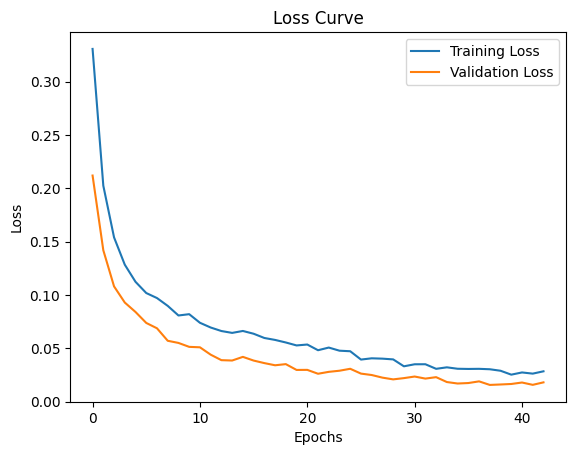

In [206]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.show()

In [207]:
best_model.save('Drone_LSTM.h5')

In [208]:
load_model = tf.keras.models.load_model('Drone_LSTM.h5')

In [209]:
load_model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 96)                  │          56,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 96)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 128)                 │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,187 (301.52 KB)

 Trainable params: 77,185 (301.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [210]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_probs = load_model.predict(X_test)
y_pred = (y_pred_probs > .5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average=None, zero_division=0)
recall = recall_score(y_test, y_pred, average=None, zero_division=0)
f1 = f1_score(y_test, y_pred, average=None, zero_division=0)

print('Test Set Evaluation:')
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall}')
print(f'f1: {f1}')
print(f'precision: {precision}')


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Set Evaluation:
Accuracy: 0.9936
Recall: [0.99726402 0.99171843]
f1: [0.99048913 0.99515235]
precision: [0.98380567 0.99861015]
